In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import random
import datetime
import tensorflow as tf
from tensorflow.keras.optimizers import Adam,SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,LSTM,TimeDistributed
from keras.layers import Convolution2D, MaxPooling2D,MaxPooling1D,Conv1D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

# Basic Parameters
This cell contains all the basic parameters required for loading the STFT, extracting MFCC.



In [ ]:
Fs = 16000
sr = 16000
n_fft = 1024
n_mfcc = 64
hop_length = 512
win_length = 1024

In [ ]:
def convert_y(y_pred,dim):
  ## This function converts the given predicted y into one-hot vector.
  Y = []
  if(dim==3):
    for i in range(len(y_pred)):
      index = np.argmax(y_pred[i])
      if (index==0):
        Y.append([1,0,0])
      elif(index==1):
        Y.append([0,1,0])
      else:
        Y.append([0,0,1])
  if(dim==2):
    for i in range(len(y_pred)):
      if(y_pred[i][0]>y_pred[i][1]):
        Y.append([1,0])
      else:
        Y.append([0,1])
  return np.array(Y)

In [ ]:
def computeCM(y, y_hat,dim):
  #-----------------------------------------------------------------------#

  ## Computes Confussion Matrix

  #-----------------------------------------------------------------------#
  confusion_matrix = np.zeros([dim, dim], dtype=int)
  for i in range(0,len(y)):
    i1 = np.argmax(y_hat[i])
    i2 = np.argmax(y[i])
    confusion_matrix[i2][i1] += 1
  return confusion_matrix

In [ ]:
def noise_reduction(x):
    #-----------------------------------------------------------------------#
    # this function takes -> STFT and return noise reduced STFT
    # As the given Spectrogram has the highest dB as 0, we safely assumed that any frame either containing speech or music should have 
    # its highest dB greater than -20. By getting know which frames doesn't have the highest dB of -20, we classify it as a noise and get the highest dB of that frame to 
    # convert all the frequencies to a -80. So, by doing this we eventually remove just the part of the audio signal which contains noise and remove it.
    #-----------------------------------------------------------------------# 
    xt = x.T
    k1 = -1e7
    k2 = -1e7
    index1 = []
    index2 = []
    for i in range(len(xt)):
        id = np.argmax(xt[i])
        if(xt[i][id]>-20):
            id2 = np.argmin(xt[i])
            if((xt[i][id2]>k1)and(xt[i][id2]>-80)): k1 = xt[i][id2]
        else:
            if((xt[i][id]>k2)and(xt[i][id]>-80)): k2 = xt[i][id]
            index2.append(i)
            ind_max = np.argpartition(xt[i], -20)[-20:]
            k_max = np.sum(xt[i][ind_max])/20
            if k_max<-50:
                index1.append(i)
    
    if(k1<k2): k = k2
    else: k = k1

    avg = 0
    ni = 0
    
    for i in index1:
        z = xt[i][:]
        avg1 = np.sum(z)/len(z)
        avg = (avg1 + (avg*ni))/(ni+1)
        ni += 1
        z[z<0] = -80
        xt[i][:] = z
    if(len(index1)==0):
        for i in index2:
            z = xt[i][:]
            avg1 = np.sum(z)/len(z)
            avg = (avg1 + (avg*ni))/(ni+1)
            ni += 1
            z[z<0] = -80
            xt[i][:] = z
    return xt.T

In [ ]:
def stft_to_mfcc(x,Fs,n_mfcc):

    #-----------------------------------------------------------------------#
    # This function returns MFCCs of each 4 frames of the given STFT
    #-----------------------------------------------------------------------#
    
    x_mfcc = []
    xt = x.T
    for i in range(0,312,4):
        mfcc = librosa.feature.mfcc(S = xt[:][i:i+4].T, sr = Fs, n_mfcc = n_mfcc)
        if(len(mfcc[0])*(len(mfcc))==64*4):
            x_mfcc.append(mfcc)
        if(len(x_mfcc[0])==78):break
    return np.array(x_mfcc)

In [ ]:
def on_offset(x):

    #-----------------------------------------------------------------------#
    # This function takes the noise reduced STFT and returns the index of the frame
    # where the spectrogram changes from silence to Music/Speech , Music/Speech to silence.
    # This is achieved by subtracting a the average of STFT along each frames and subtracting it with an numpy array which contains just -80 as each element.
    # By subtracting we get an array of 1 X 313 with 0 in the frames which contain silence and an non zero value when there is a speech of music.
    #-----------------------------------------------------------------------#
    
    x_avg = np.sum(x,axis=0)/len(x)
    x_avg = np.array(x_avg)
    t = np.full(len(x[0]), -80)
    k = np.subtract(x_avg,t)
    k = k.astype(int)

    on = []
    b = []
    on.append(0)
    for i in range(len(k)-1):
        l = len(on)
        if(k[i]==0):
            if(k[i+1]!=0):
                  if((i-on[l-1])>=4):
                    on.append(i)
                    b.append(0)
        else:
            if(k[i+1]==0):
                  if((i-on[l-1])>=4):
                    on.append(i)
                    b.append(1)
    if(313-on[len(on)-1]>=4):
      on.append(313)
      if(k[312]==0):
        b.append(0)
      else:
        b.append(1)
    # on2 = []
    # for i in range(len(on)-1):
    #   if(on[i+1]-on[i]>=12):
    #     on2.append(on[i])
    # on2.append(on[len(on)-1])
    return np.array(on),np.array(b)

In [ ]:
Linear_model = tf.keras.models.load_model("/content/drive/MyDrive/model weights/Linear_model.tf")
CNN_model = tf.keras.models.load_model("/content/drive/MyDrive/model weights/cnn_corrected.h5")

In [ ]:
path = "/content/drive/MyDrive/mock_spectrogram/"
# path = "Speech/Spectrogram/"

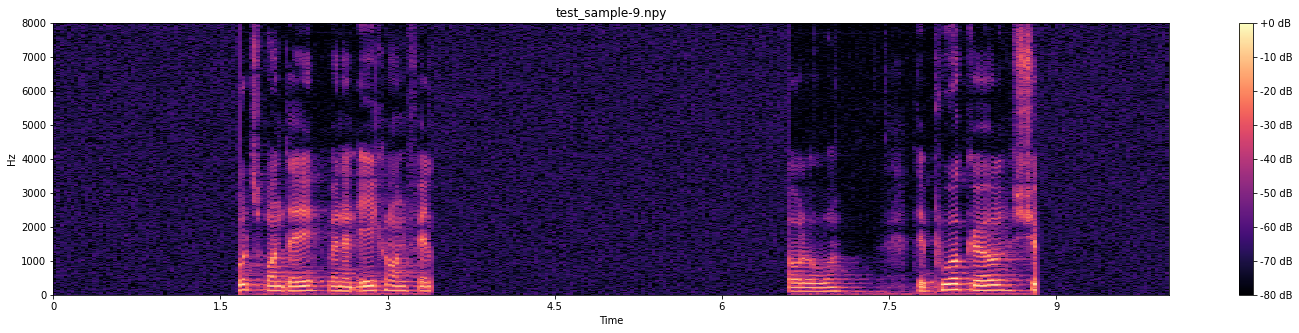

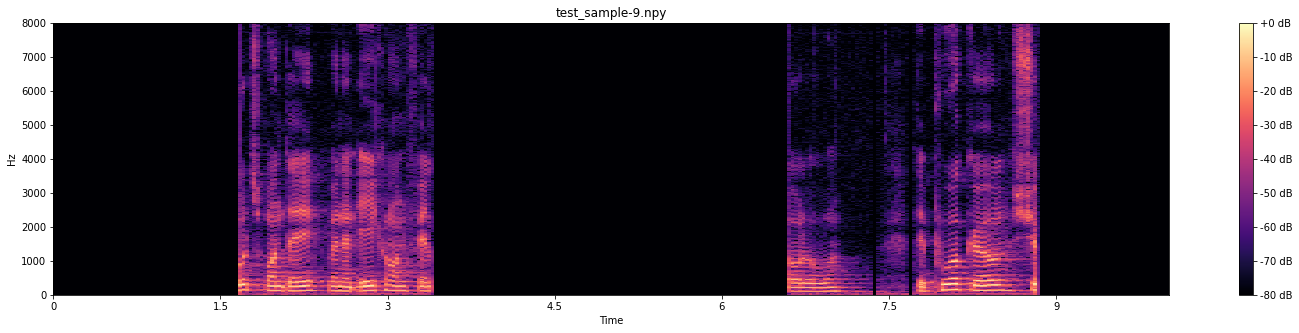

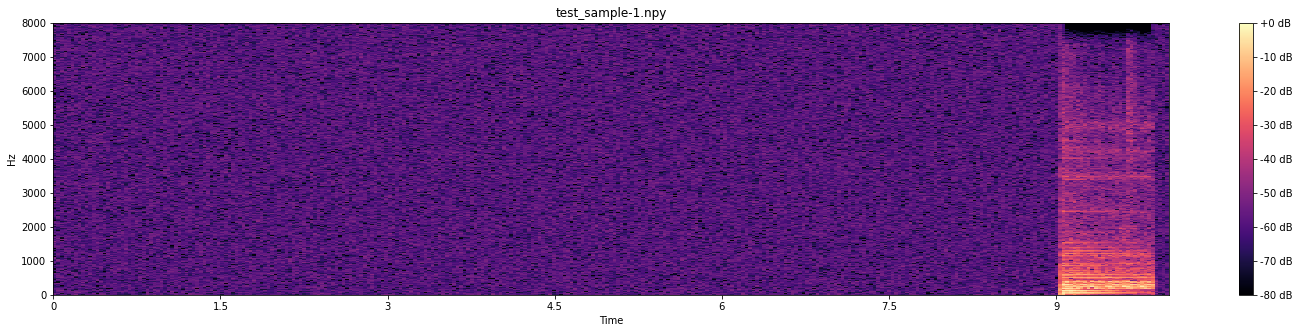

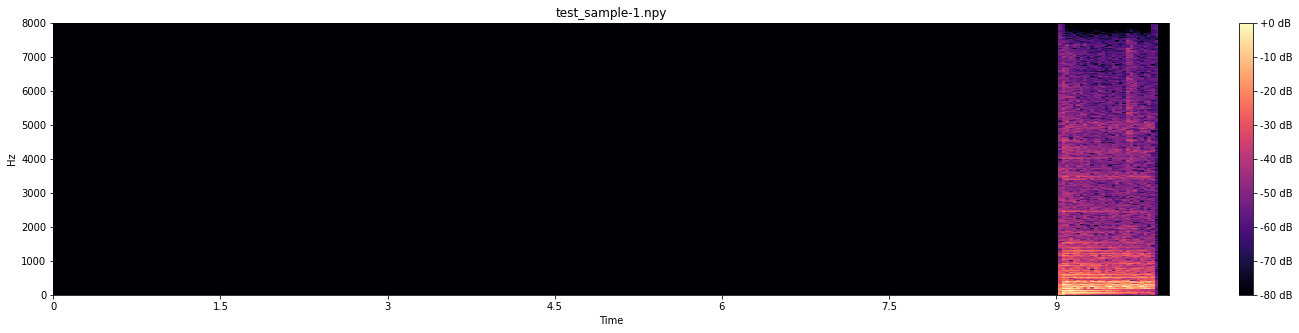

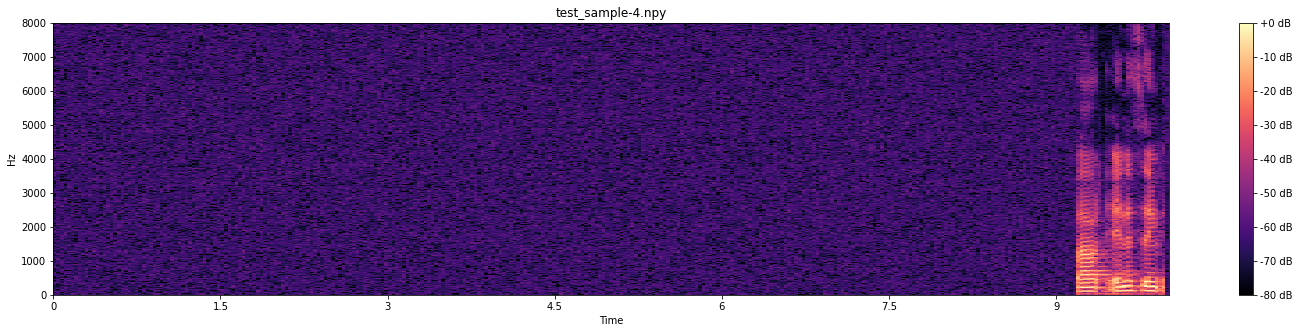

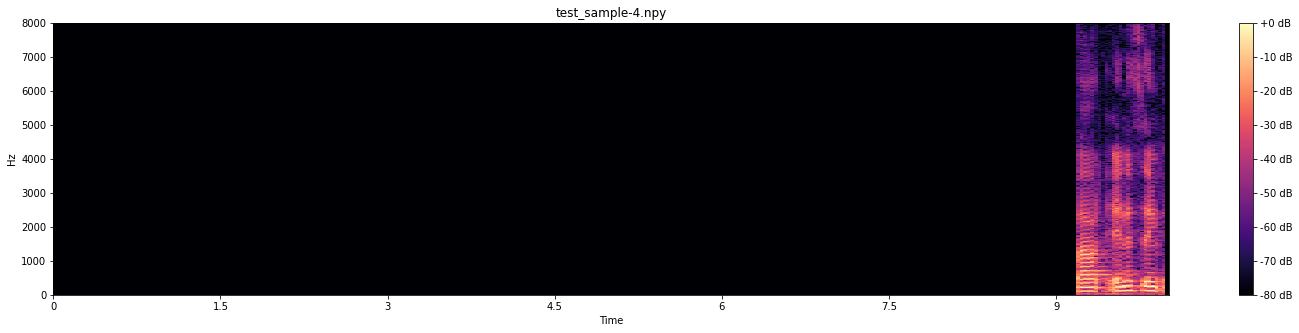

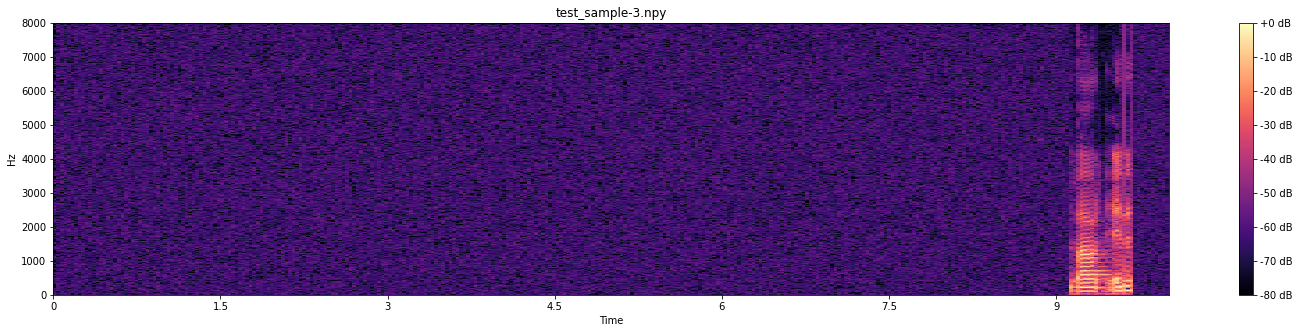

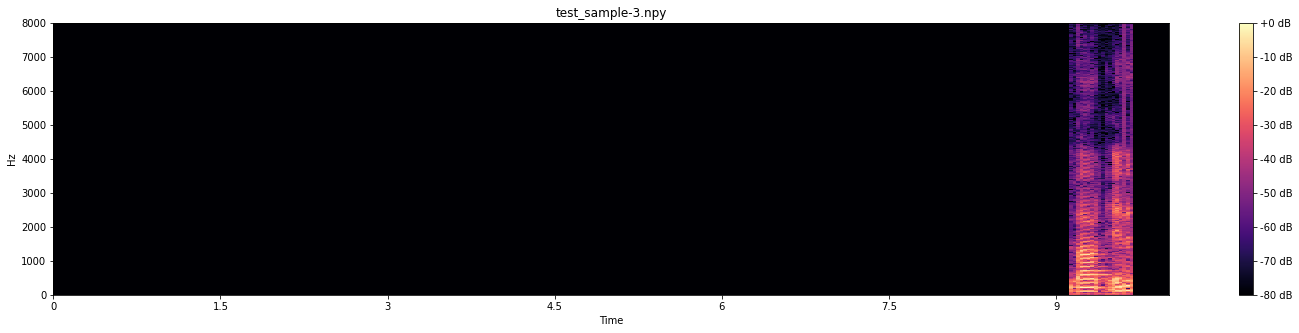

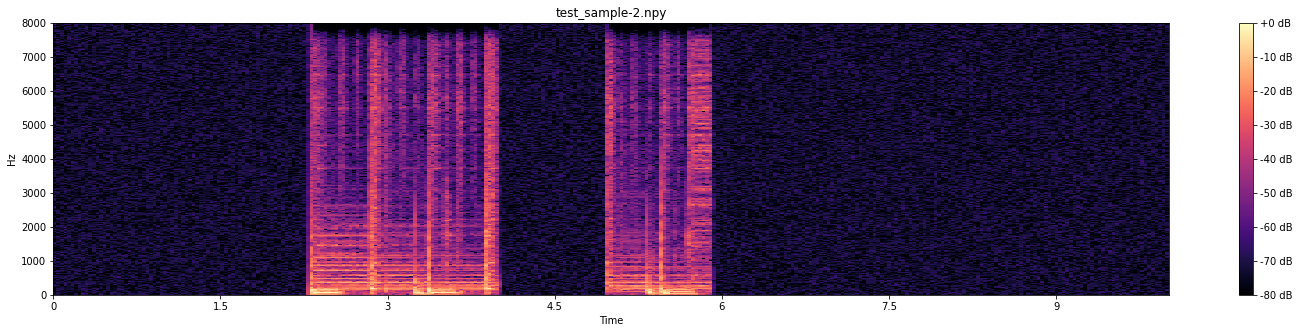

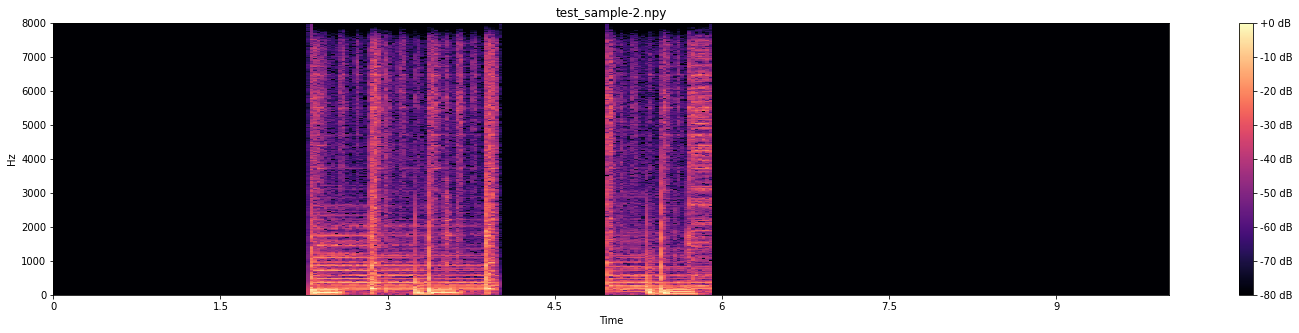

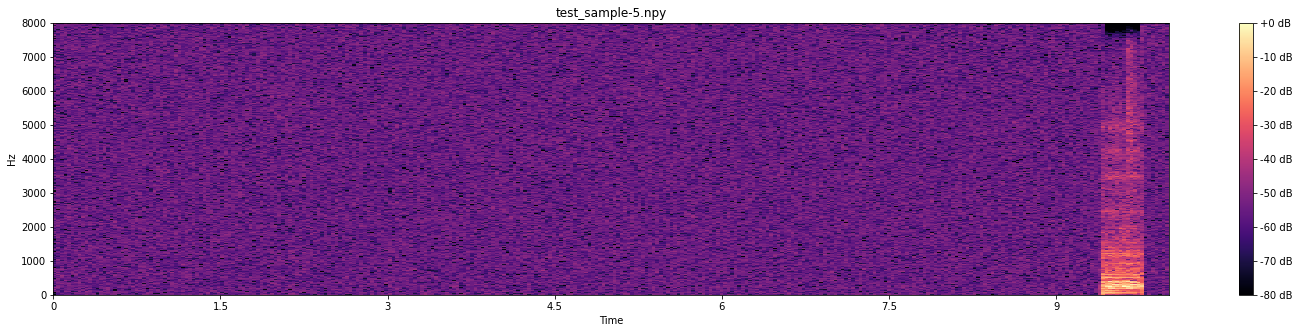

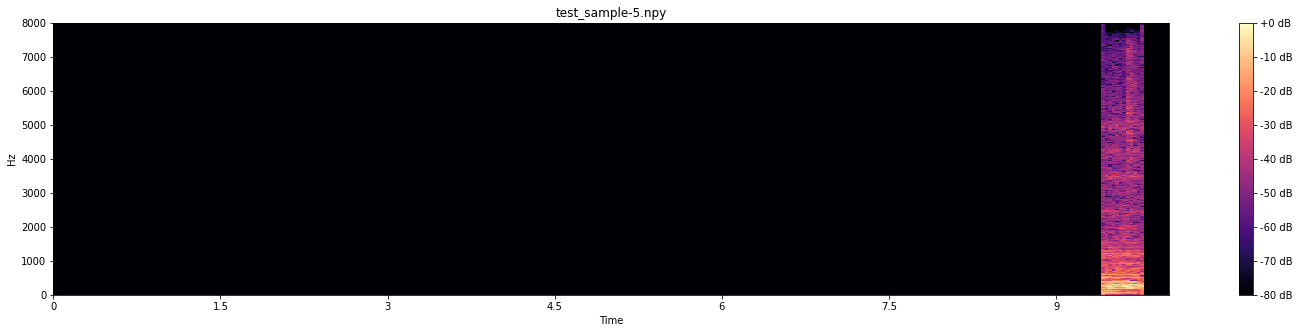

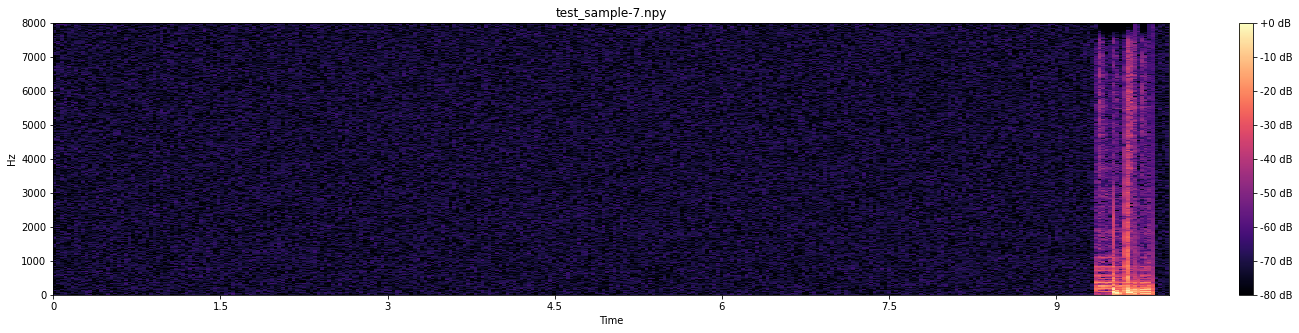

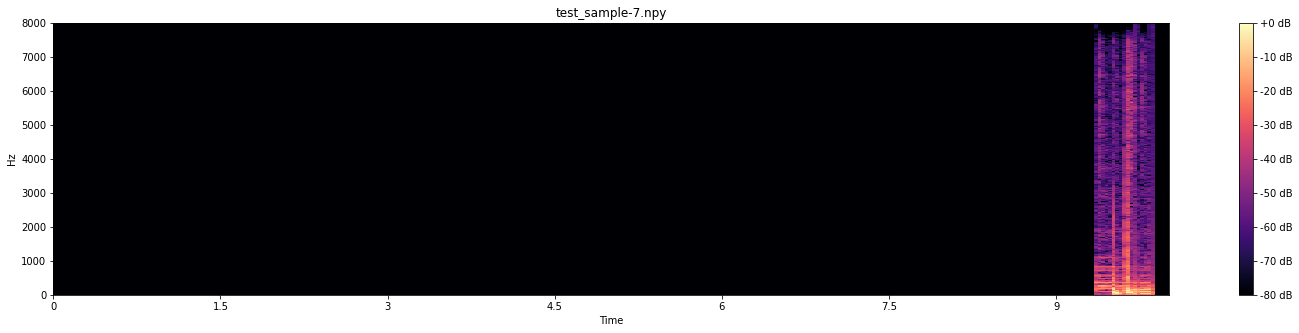

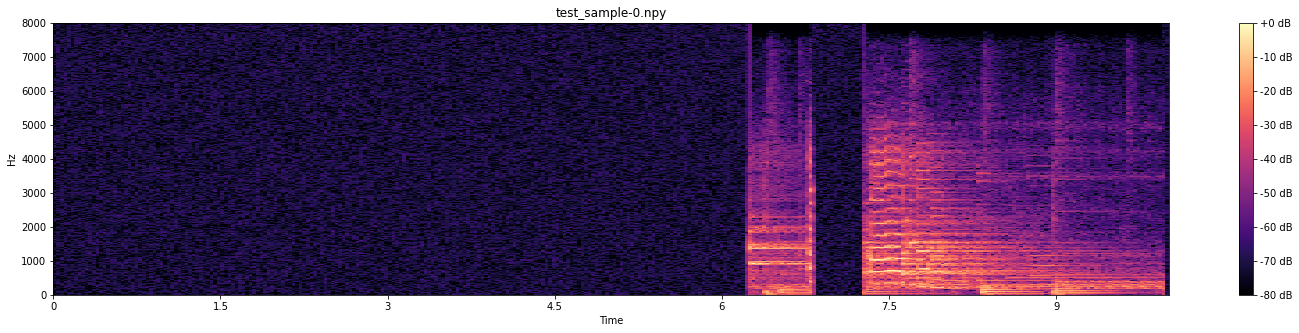

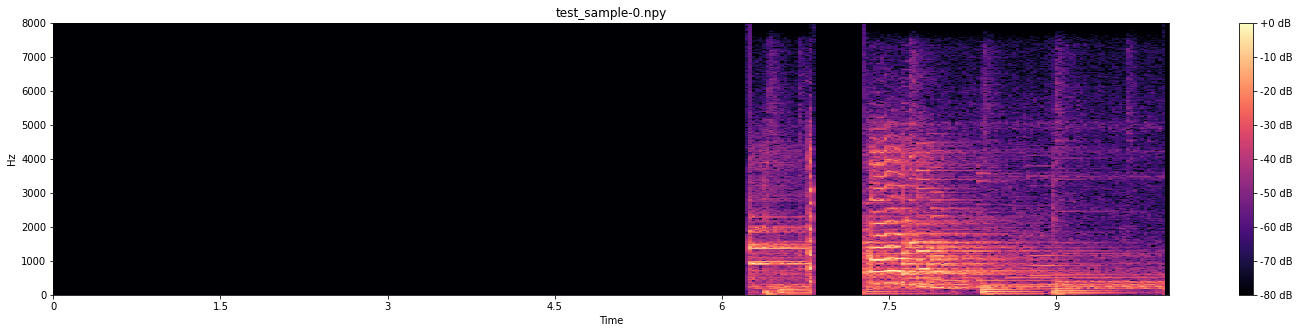

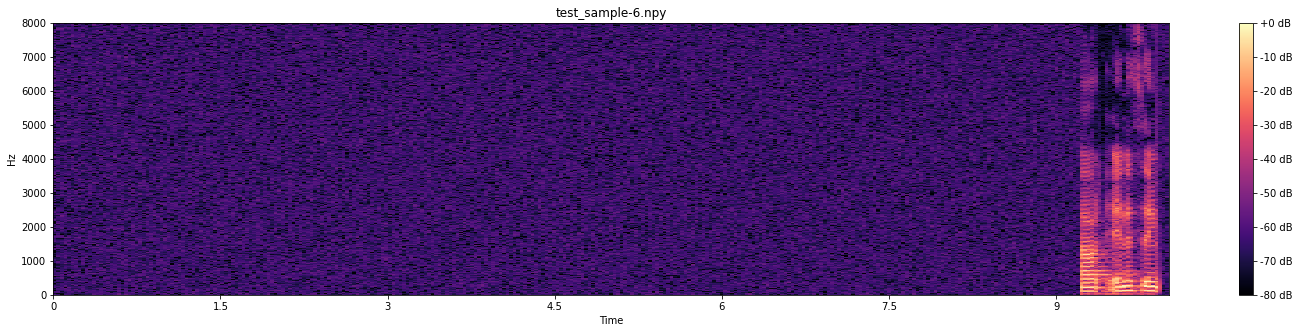

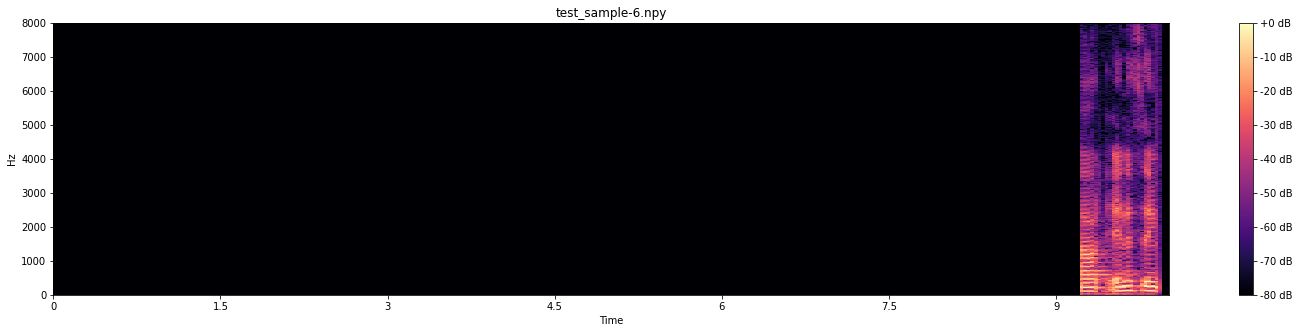

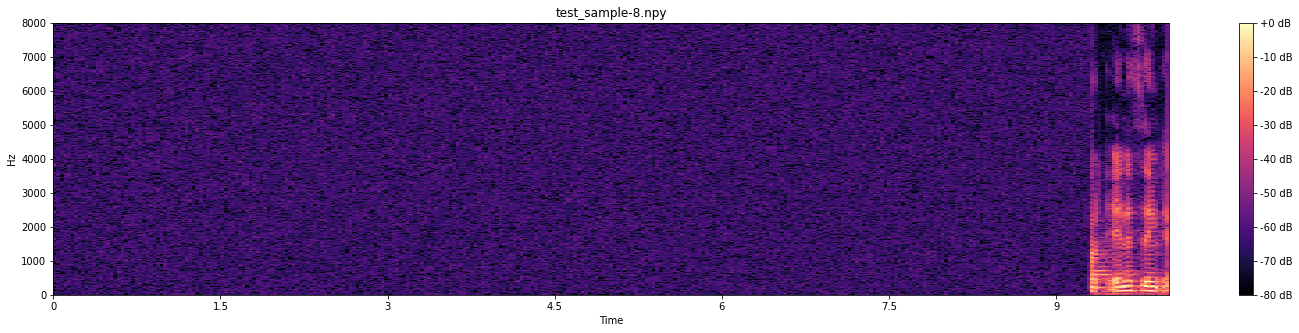

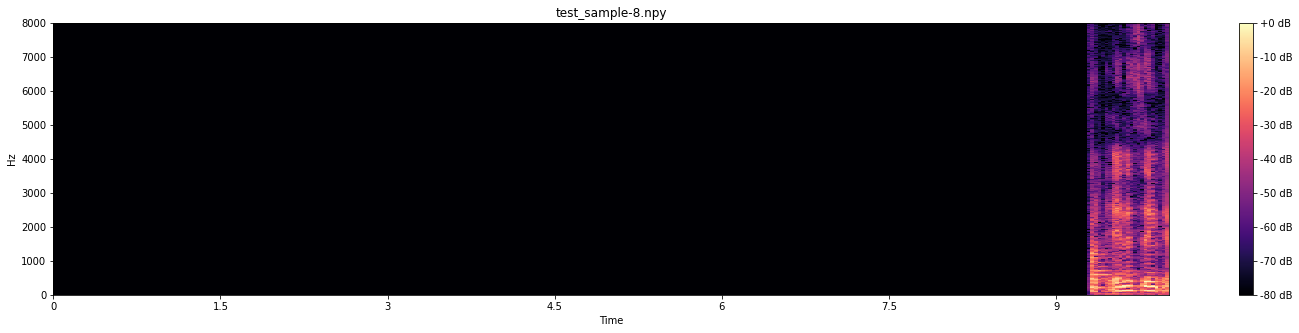

In [490]:
on_off = []
B = []
stft_raw = []
stft = []
file_names = []
for file in os.listdir(path):
    if(file.endswith(".npy")):
      file_names.append(file)
      a = np.load(path+file)
      stft_raw.append(np.load(path+file))

      plt.figure(figsize=(25, 5))
      librosa.display.specshow(a, sr=Fs, hop_length=hop_length, x_axis='time', y_axis='linear')
      plt.colorbar(format='%+2.0f dB')
      plt.title(file)

      a = noise_reduction(a)
      if(len(a[0])==314): continue

      plt.figure(figsize=(25, 5))
      librosa.display.specshow(a, sr=Fs, hop_length=hop_length, x_axis='time', y_axis='linear')
      plt.colorbar(format='%+2.0f dB')
      plt.title(file)
  
      o1,b1 = on_offset(a)
      B.append(b1)
      on_off.append(o1)
      stft.append(a)

# stft.shape

In [491]:
stft = np.array(stft)

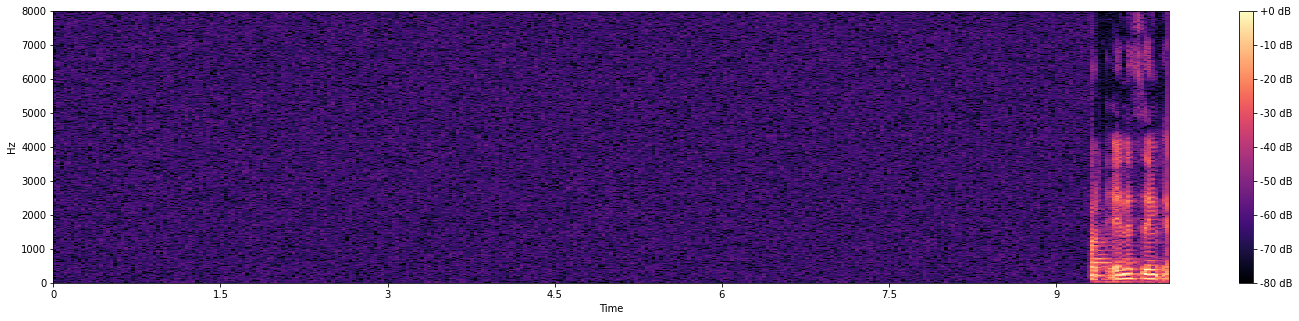

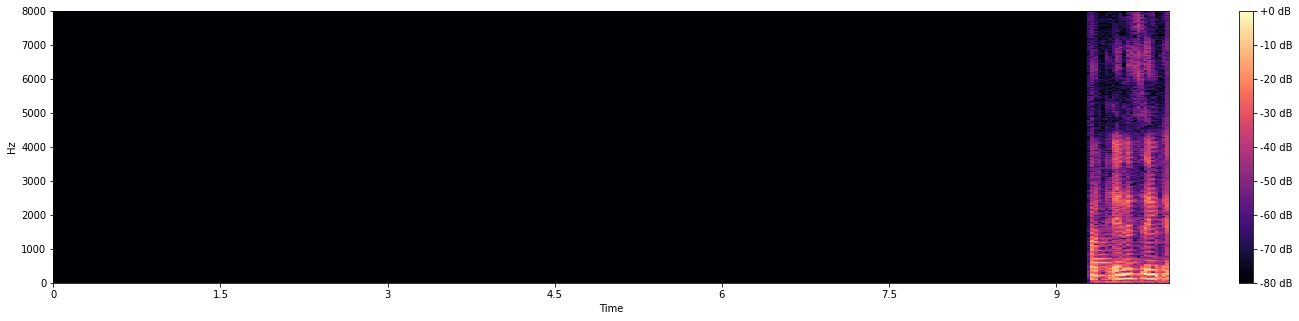

In [492]:
# Plotting of a single spectrogram

i = 9

plt.figure(figsize=(25, 5))
librosa.display.specshow(stft_raw[i], sr=Fs, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')


plt.figure(figsize=(25, 5))
librosa.display.specshow(stft[i], sr=Fs, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')


In [493]:
Y_pred = []
for i in range(len(on_off)):
# i = 1
# print(i)
  stft_i = np.array(stft[i])
  xt = stft_i.T
  Y1 = []
  for j in range(len(on_off[i])-1):
      x_c = []
      x_l = []
      if(B[i][j]!=0):
        for k in range(on_off[i][j],on_off[i][j+1],4):
            if((k+4)<313):mfcc = librosa.feature.mfcc(S = xt[:][k:k+4].T, sr = Fs, n_mfcc = n_mfcc)
            z = mfcc.flatten()
            z = np.array(z)
            if(len(z)==64*4):
              x_c.append(mfcc)
        x_c = np.array(x_c)
        y2_pred = CNN_model.predict(x_c)
        Y2_pred = convert_y(y2_pred,3)
      else:
        for k in range(on_off[i][j],on_off[i][j+1],4):
            if((k+4)<313):
              mfcc = librosa.feature.mfcc(S = xt[:][k:k+4].T, sr = Fs, n_mfcc = n_mfcc)
              z = mfcc.flatten()
              z = np.array(z)
              if(len(z)==64*4):
                x_l.append(z)

        if(len(x_l)!=0):
          x_2 = np.array(x_l)          
          y2_pred = Linear_model.predict(x_2)
          Y2_pred = convert_y(y2_pred,3)
      Y1.append(np.sum(Y2_pred,axis=0))
  Y_pred.append(Y1)

In [494]:
on_off_time = []
final_pred = []
for i in range(len(on_off)):
    oot1 = []
    fp1 = []
    for j in range(len(on_off[i])):
        t = (on_off[i][j]*10)/313
        oot1.append(t)
    for j in range(len(Y_pred[i])):
        id = np.argmax(Y_pred[i][j])
        k = id
        if(id==2):
            if(Y_pred[i][j][0]+Y_pred[i][j][1])==0:
                k = id
            else:
                if(Y_pred[i][j][0]+Y_pred[i][j][1])<Y_pred[i][j][id]:
                    if(Y_pred[i][j][id]-(Y_pred[i][j][0]+Y_pred[i][j][1])) > 5:
                        k = id
                    else:
                        if(Y_pred[i][j][0]>Y_pred[i][j][1]):
                            k = 0
                        else:
                            k = 1
                else:
                    if(Y_pred[i][j][0]>Y_pred[i][j][1]):
                        k = 0
                    else:
                        k = 1
        else:
            k = id
        fp1.append(k)
        
    on_off_time.append(oot1)
    final_pred.append(fp1)

Timeline:  [0.0, 1.6293929712460065, 3.3865814696485623, 6.5495207667731625, 7.31629392971246, 7.635782747603834, 8.817891373801917, 10.0]
Prediction of each clip:  [2, 1, 2, 1, 1, 1, 2]
test_sample-9.npy


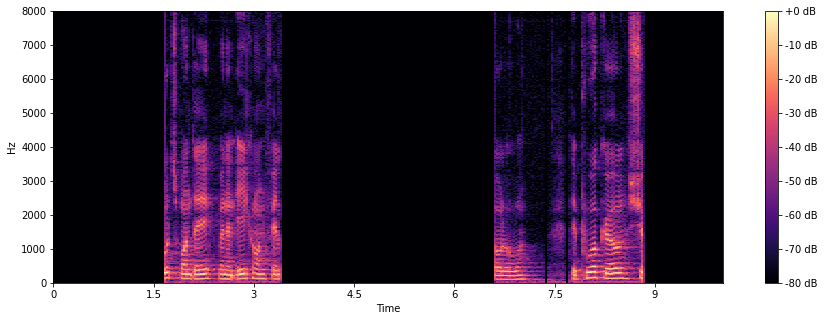

In [496]:
i = 0

print("Timeline: ",on_off_time[i])
print("Prediction of each clip: ",final_pred[i])
print(file_names[i])

plt.figure(figsize=(15, 5))
librosa.display.specshow(stft[i], sr=Fs, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')

In [497]:
task1 = []
no_sec = []
for i in range(len(final_pred)):

    tm = 0.0
    ts = 0.0
    n_k = []
    n_k.append(file_names[i])
    
    
    for j in range(len(final_pred[i])):
        k = []
        if(final_pred[i][j]==0):

            k.append(file_names[i])
            k.append("Music")
            k.append(on_off_time[i][j])
            k.append(on_off_time[i][j+1])
            
            task1.append(k)

            tm += on_off_time[i][j+1]-on_off_time[i][j]

        elif(final_pred[i][j]==1):

            k.append(file_names[i])
            k.append("Speech")
            k.append(on_off_time[i][j])
            k.append(on_off_time[i][j+1])

            task1.append(k)
            ts += on_off_time[i][j+1]-on_off_time[i][j]
    n_k.append(tm)
    n_k.append(ts)
    no_sec.append(n_k)

In [ ]:
i=0
while i<len(task1):
  print(i)
  if i<len(task1)-1:
    if(task1[i][3]==task1[i+1][2]):
      task1[i][3]=task1[i+1][3]
      task1.pop(i+1)
      i=i-1
  i=i+1

  

In [499]:
task2 = []
for i in range(len(no_sec)):
  k = []
  k.append(no_sec[i][0])
  if(no_sec[i][1]>0):
    k.append(1)
  else:
    k.append(0)
  if(no_sec[i][2]>0):
    k.append(1)
  else:
    k.append(0)
  task2.append(k)

In [500]:
import csv
import pandas as pd

In [501]:
task1_headerList = ['filename', 'event', 'onset', 'offset']
df = pd.DataFrame(task1,columns=task1_headerList)
df.to_csv('/content/drive/MyDrive/task1.csv',index=False)

In [502]:
task2_headerList =['filename', 'music', 'speech']
df = pd.DataFrame(task2,columns=task2_headerList)
df.to_csv('/content/drive/MyDrive/task2.csv',index=False)

In [503]:
nosec_headerList =['filename', 'total_music', 'total_speech']
df = pd.DataFrame(no_sec,columns=nosec_headerList)
df.to_csv('/content/drive/MyDrive/nofsec.csv',index=False)
